# Laboratorium 07 — Detekcja obiektów — obrazy mikroskopowe krwi (BCCD)

W tym ćwiczeniu zajmiemy się problemem **detekcji obiektów** na obrazach medycznych. Zaimplementujemy od podstaw własną architekturę sieci, która w uproszczony sposób naśladuje działanie modeli typu Faster R-CNN.

**Cele zajęć:**
- Implementacja własnego datasetu dla zadania object detection z augmentacjami.
- Zrozumienie architektury sieci detekcyjnej: **backbone**, **RPN** (Region Proposal Network), **detection head**.
- Poznanie koncepcji **anchor boxes** i ich generowania.
- Implementacja funkcji straty dla detekcji: klasyfikacja obiekt/tło + regresja bounding boxów.
- Trening i ewaluacja modelu z wykorzystaniem metryki **mAP** (mean Average Precision).

**Dataset:**  
**BCCD (Blood Cell Count and Detection)** — zbiór obrazów mikroskopowych krwi z adnotacjami 3 klas komórek: białe krwinki (WBC), czerwone krwinki (RBC) i płytki krwi (Platelets). Zbiór zawiera 364 obrazy z adnotacjami. W notebooku wykorzystujemy bibliotekę **Albumentations** do augmentacji zachowujących spójność pomiędzy obrazem a bounding boxami.

## 0. Środowisko i instalacja pakietów

Przed rozpoczęciem pracy upewnij się, że masz zainstalowane wymagane biblioteki. Jeśli którejś brakuje, odkomentuj i uruchom poniższą komórkę.

In [2]:
# Jeśli brakuje pakietów, odkomentuj i uruchom:
!pip install -U pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install pytorch-lightning torchmetrics[detection]
!pip install albumentations opencv-python matplotlib lxml rich

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 24.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 43.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pytorch-lightning]


## 1. Importy i ustawienia

Importujemy niezbędne biblioteki oraz konfigurujemy urządzenie obliczeniowe i precyzję operacji.

In [3]:
import os, random, json
from pathlib import Path
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

import pytorch_lightning as pl
from pytorch_lightning import seed_everything

import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rich import print

from collections import Counter

from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt
import torch

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import box_iou, nms, roi_align

# seed_everything(42, workers=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configure TF32 precision
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    torch.set_float32_matmul_precision('medium')  # 'medium' or 'high' for speed, 'highest' for accuracy


Using device: cuda

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


## 2. Pobranie danych

Dane zostaną automatycznie pobrane przez sklonowanie repozytorium GitHub.

In [4]:
root = Path("data/data_bccd")
if not root.exists():
    root.mkdir(parents=True, exist_ok=True)
    exit_code = os.system(f"git clone --depth 1 https://github.com/Shenggan/BCCD_Dataset.git {root}")
    if exit_code != 0:
        print("Uwaga: nie udało się wykonać `git clone`.")
        print("https://github.com/Shenggan/BCCD_Dataset")

ann_dir = root / "BCCD/Annotations"
img_dir = root / "BCCD/JPEGImages"
set_dir = root / "BCCD/ImageSets/Main"

assert ann_dir.exists() and img_dir.exists() and set_dir.exists(), "Brakuje katalogów Annotations/JPEGImages/ImageSets."

xmls = sorted(list((ann_dir).glob("*.xml")))
imgs = sorted(list((img_dir).glob("*.jpg")))
print(f"Liczba adnotacji: {len(xmls)}, liczba obrazów: {len(imgs)}")

Liczba adnotacji: 364, liczba obrazów: 364

## 3. Parser VOC XML i mapowanie etykiet

Format Pascal VOC przechowuje adnotacje obiektów w plikach XML (ścieżka `ann_dir`) i podział na zbiory treningowy, testowy i walidacyjny (ścieżka `set_dir`). Każdy plik XML zawiera informacje o obrazie (rozmiar) oraz listę obiektów z ich współrzędnymi bounding boxów i etykietami klas. Poniżej jest zaimplementowana funkcja która wczytuje dane odnośnie prostokątów otaczających z podanego pliku XML.

W tej sekcji:
- Zdefiniowane są nazwy klas i tworzone mapowania między nazwami a indeksami (indeksy 1-3 dla klas, 0 jest zarezerwowane dla tła).
- Implementowano parser XML, który wydobywa współrzędne prostokątów i etykiety.

In [5]:
CLASS_NAMES = ["WBC", "RBC", "Platelets"]
NAME_TO_IDX = {name: i+1 for i, name in enumerate(CLASS_NAMES)}
IDX_TO_NAME = {i+1: name for i, name in enumerate(CLASS_NAMES)}
NUM_CLASSES = len(CLASS_NAMES) + 1  # + background

def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    size = root.find("size")
    W = int(size.find("width").text)
    H = int(size.find("height").text)
    boxes, labels = [], []
    for obj in root.findall("object"):
        name = obj.find("name").text.strip()
        name = name.replace("Platelet", "Platelets")
        bnd = obj.find("bndbox")
        xmin = float(bnd.find("xmin").text)
        ymin = float(bnd.find("ymin").text)
        xmax = float(bnd.find("xmax").text)
        ymax = float(bnd.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(NAME_TO_IDX.get(name, 0))
    return np.array(boxes, dtype=np.float32), np.array(labels, dtype=np.int64), (H, W)

## Zadanie 1 – Dataset, augmentacje i DataModule

W tym zadaniu zaimplementujemy klasy do wczytywania danych dla zadania detekcji z datasetu BCCD.

**Kluczowe różnice w porównaniu do klasyfikacji i segmentacji:**
- Dane wyjściowe to nie pojedyncza etykieta ani maska, ale **lista bounding boxów** i **lista etykiet** dla każdego obrazu.
- Augmentacje muszą transformować zarówno obraz jak i współrzędne bounding boxów (np. przy flip'ie musimy też przesunąć współrzędne).
- Używamy biblioteki **Albumentations**, która obsługuje augmentacje dla prostokątów otaczających.

**Dataset (BCCDDataset):**
1. Zaimplementuj klasę `BCCDDataset`, która dziedziczy po `Dataset`.
2. Metoda `__init__`:
   - Pryjmuje i zapamiętuje ścieżki do katalogów z obrazami (`img_dir`) i adnotacjami (`ann_dir`).
   - Kolejnym argumentem jest lista identyfikatorów obrazów (`indices`) — nazwy plików w danym zbiorze.
   - Ostatnim jest obiekt transformacji (`transforms`).
3. W metodzie `__len__` zwróć liczbę próbek.
4. W metodzie `__getitem__`:
   - Argumentem jest indeks pobieranej próbki.
   - Pobierz identyfikator obrazu z listy identyfikatorów na podstawie indeksu.
   - Skonstruuj ścieżki do pliku obrazu (`.jpg`) i adnotacji (`.xml`). Do ścieżek dodaj identyfikator i rozszerzenie.
   - Wczytaj obraz za pomocą `cv2.imread` i przekonwertuj z BGR na RGB.
   - Wczytaj plik z etykietami za pomocą funkcji `parse_voc_xml`.
   - Upewnij się, że wszystkie prostokąty mają poprawne współrzędne (`x2 > x1` i `y2 > y1`). Jeśli nie, odfiltruj niepoprawne boxy.
   - Jeśli `self.transforms` istnieje, zastosuj transformacje przekazując obraz, listę prostokątów oraz listę etykiet. Konwersję do listy wykonaj za pomocą metody `.tolist()`. Albumentations zwraca słownik z kluczami `"image"`, `"bboxes"`, `"class_labels"`.
   - Skonwertuj wynikowe prostokąty i etykiety z powrotem na `np.array`.
   - Przygotuj słownik `target` z kluczami:
     - `"boxes"` — tensor typu `float32` z bounding boxami.
     - `"labels"` — tensor typu `int64` z etykietami klas.
     - W formacie COCO są jeszcze dodatkowe pola (`"image_id"`, `"area"`, `"iscrowd"`), ale nie są one w naszej implementacji potrzebne.
   - Zwróć obrazy i docelowe prostokąty.

**Funkcja collate:**
1. Funkcja ta mówi w jaki sposób wczytane dane mają być łączone w batch. Dla zadania detekcji w kolejnych próbkach liczba prostokątów może być różna, więc łatwiej może być te dane połączyć w listę, zamiast tensor.
2. Zaimplementuj funkcję `collate_fn(batch)`:
   - Rozpakuj obrazy i targety: `imgs, targets = list(zip(*batch))` do dwóch osobnych list.
   - Zwróć te listy.

**DataModule (BCCDDataModule):**
1. Zaimplementuj klasę `BCCDDataModule`, która dziedziczy po `pl.LightningDataModule`.
2. Argumentami metody `__init__` są ścieżki do katalogów z obrazami, adnotacjami i podziałem zbiorów, rozmiar batcha i liczba workerów:
   - Zapamiętaj przekazane argumenty.
   - Zdefiniuj transformacje treningowe za pomocą `A.Compose`:
     - `A.RandomBrightnessContrast` — losowa zmiana jasności i kontrastu, jako argument przekaż prawdopodobieństwo,
     - `A.HorizontalFlip()` — losowe odbicie poziome, jako argument przekaż prawdopodobieństwo,
     - `A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))` — gdy nie używamy pretrenowanych wag do ResNet, `A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))` gdy używamy,
     - `A.ToTensorV2()` — konwersja do tensora PyTorch,
     - Przekaż `bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"])` jako argument dla funkcji `A.Compose`, aby Albumentations wiedziało jak modyfikować prostokąty.
   - Zdefiniuj transformacje walidacyjne analogicznie, ale bez augmentacji (tylko `A.NoOp()`, normalizacja i konwersja do tensora).
3. Zaimplementuj metodę pomocniczą, która przyjmuje plik podziału na zbiory jako argument:
   - Zwróć listę identyfikatorów (każda linia to jedna nazwa pliku):
   `with open(split_path, 'r') as f: ids = [line.strip() for line in f if line.strip()]`
4. W metodzie `setup(self, stage=None)`:
   - Wczytaj identyfikatory dla train, val i test używając zaimplementowanej metody pomocniczej.
   - Stwórz trzy datasety za pomocą zaimplementowanej wcześniej klasy, przekazując odpowiednie katalogi, identyfikatory i transformacje.
   - Wyświetl rozmiary zbiorów.
5. Zaimplementuj metody `train_dataloader()`, `val_dataloader()`, `test_dataloader()`:
   - Zwróć `DataLoader` z odpowiednim datasetem.
   - Ustaw `shuffle` tylko dla train.
   - Przekaż rozmiar batcha i liczbę workerów.
   - Ustaw `collate_fn=collate_fn`.

**Poza klasami:**
1. Stwórz instancję `BCCDDataModule` z odpowiednimi ścieżkami i parametrami.
2. Wywołaj `setup()`.
3. Pobierz dataloadery z zaimplementowanej ze stworzonej instancji.

In [6]:
class BCCDDataset(Dataset):
  def __init__(self, img_dir, ann_dir, indices, transforms=None):
    self.img_dir = img_dir
    self.ann_dir = ann_dir
    self.indices = indices
    self.transforms = transforms

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, idx):
      img_id = self.indices[idx]
      img_path = (self.img_dir / img_id).with_suffix(".jpg")
      ann_path = (self.ann_dir / img_id).with_suffix(".xml")

      img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)

      boxes, labels, _ = parse_voc_xml(ann_path)
      boxes = boxes[boxes[:, 2] > boxes[:, 0]]  # x2 > x1
      boxes = boxes[boxes[:, 3] > boxes[:, 1]]  # y2 > y1

      if len(boxes) != len(labels):
        min_len = min(len(boxes), len(labels))
        boxes = boxes[:min_len]
        labels = labels[:min_len]

      if self.transforms is not None:
        transformed = self.transforms(
            image=img,
            bboxes=boxes.tolist(),
            class_labels=labels.tolist()
        )
        img = transformed["image"]
        boxes = np.array(transformed["bboxes"])
        labels = np.array(transformed["class_labels"])

        if len(boxes) != len(labels):
          min_len = min(len(boxes), len(labels))
          boxes = boxes[:min_len]
          labels = labels[:min_len]

      target = {
        "boxes": torch.as_tensor(boxes, dtype=torch.float32),
        "labels": torch.as_tensor(labels, dtype=torch.int64)
      }

      return img, target

In [7]:
def collate_fn(batch):
  imgs, targets = list(zip(*batch))
  return imgs, targets

In [8]:
class BCCDDataModule(pl.LightningDataModule):
  def __init__(self, img_dir, ann_dir, set_dir, batch_size, num_workers, pretrained=torch._functional_assert_async):
    super().__init__()
    self.img_dir = img_dir
    self.ann_dir = ann_dir
    self.set_dir = set_dir
    self.batch_size = batch_size
    self.num_workers = num_workers

    self.train_transforms = A.Compose([A.RandomBrightnessContrast(p=0.5),
                                       A.HorizontalFlip(p=0.5),
                                       A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) if not pretrained else A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                                       A.ToTensorV2()],
                                       bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))

    self.val_transforms = A.Compose([A.NoOp(),
                                     A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) if not pretrained else A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                                     A.ToTensorV2()],
                                     bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))

  def __split_ids(self, split_path):
    with open(split_path, 'r') as f:
      ids = [line.strip() for line in f if line.strip()]

    return ids

  def setup(self, stage=None):
    train_ids = self.__split_ids(self.set_dir / "train.txt")
    val_ids = self.__split_ids(self.set_dir / "val.txt")
    test_ids = self.__split_ids(self.set_dir / "test.txt")

    self.train_ds = BCCDDataset(self.img_dir, self.ann_dir, train_ids, self.train_transforms)
    self.val_ds = BCCDDataset(self.img_dir, self.ann_dir, val_ids, self.val_transforms)
    self.test_ds = BCCDDataset(self.img_dir, self.ann_dir, test_ids, self.val_transforms)

    print(f"Train: {len(self.train_ds)}, Val: {len(self.val_ds)}, Test: {len(self.test_ds)}")

  def train_dataloader(self):
      return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, collate_fn=collate_fn)


  def test_dataloader(self):
      return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, collate_fn=collate_fn)


  def val_dataloader(self):
      return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, collate_fn=collate_fn)


In [9]:
BATCH_SIZE = 8
NUM_WORKERS = 4

dm = BCCDDataModule(img_dir, ann_dir, set_dir, BATCH_SIZE, NUM_WORKERS)
dm.setup()

Train: 205, Val: 87, Test: 72

## Zadanie 2 – Wizualizacja próbek z bounding boxami

Wyświetl kilka próbek ze zbioru treningowego razem z zaznaczonymi prostokątami otaczającymi.

1. Pobierz batch za pomocą `imgs, tgts = next(iter(dloader))`.
2. W pętli pobierz prostokąty i etykiety dla kolejnych próbek: `tgts[i]["boxes"]` i `tgts[i]["labels"]`.
3. Skonwertuj etykietę do nazwy za pomocą słownika `IDX_TO_NAME`: `labels_txt = [f"{IDX_TO_NAME.get(l.item(),'BG')}" for l in labels]`
4. Wygeneruj obraz z zaznaczonymi obiektami za pomocą funkcji `draw_bounding_boxes`. Przekaż jej obraz wejściowy, prostokąty i etykiety.
5. Wyświetl wynikowy obraz.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


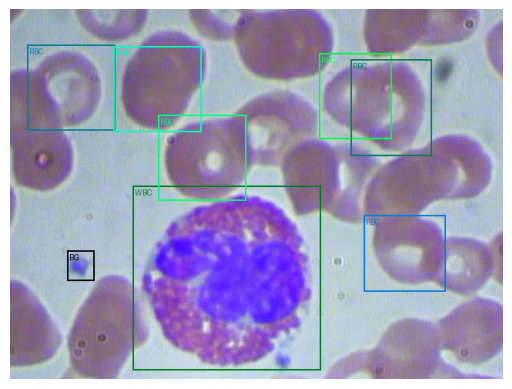

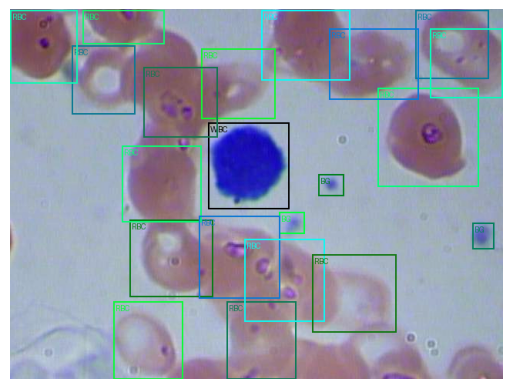

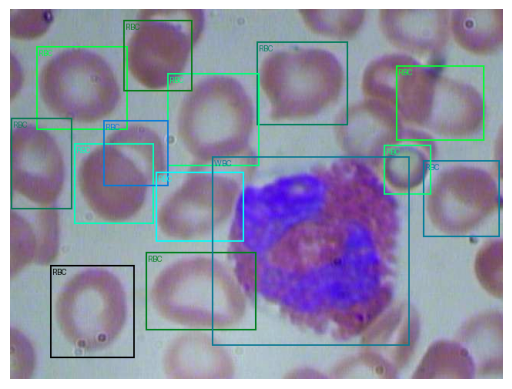

In [10]:
imgs, tgts = next(iter(dm.train_dataloader()))

for i in range(min(3, len(imgs))):
  boxes = tgts[i]["boxes"]
  labels = tgts[i]["labels"]
  labels_txt = [IDX_TO_NAME.get(l.item(),"BG") for l in labels]

  img_uint8 = (((imgs[i] - imgs[i].min()) / (imgs[i].max() - imgs[i].min())) * 255).to(torch.uint8)

  boxed = draw_bounding_boxes(
      img_uint8,
      boxes,
      labels=labels_txt,
      width=2
  )

  plt.imshow(boxed.permute(1,2,0))
  plt.axis("off")
  plt.show()


## Implementacja architektury sieci do detekcji

W kolejnych zadaniach zaimplementujemy architekturę sieci składającą się z czterech głównych komponentów: **Anchor Generator**, **Region Proposal Network**, **Detection Head** i **Detector** łączącego wszystko razem.

### Zadanie 3 – Anchor Generator

Anchor boxes to predefiniowane bounding boxy o różnych rozmiarach i proporcjach, które służą jako punkt odniesienia dla sieci. Dla każdej pozycji na feature mapie generujemy zestaw anchorów o różnych rozmiarach i kształtach.

1. Zaimplementuj klasę `AnchorGenerator`, która dziedziczy po `nn.Module`:
   - Konstruktorze przyjmuje i zapamiętuje listę rozmiarów anchorów (`sizes`) i proporcji boków (`aspect_ratios`).
   - Oblicz liczbę anchorów przypadających na jeden element z macierzy cech jako iloczyn liczby rozmiarów i liczby proporcji.
2. Zaimplementuj metodę `generate_anchors(self, feature_size, image_size, device)`:
   - Przyjmuje rozmiar mapy cech `(H, W)` i rozmiar obrazu `(img_h, img_w)`.
   - Oblicz stride (na ile pikseli w obrazie wejściowym przypada jedno pole mapy cech): `stride_h = img_h / h`, `stride_w = img_w / w`.
   - Wygeneruj współrzędne centrów anchorów dla każdej pozycji mapy cech mnożąc wektor `torch.arange(0, h, device=device, dtype=torch.float32)` przez stride i dodając połowę rozmiaru.
   - Stwórz dwuwymiarowe mapy tych współrzędnych za pomocą `torch.meshgrid(shifts_y, shifts_x, indexing='ij')`, a następnie spłaszcz je za pomocą metody `.reshape(-1)`.
   - Stwórz pustą listę na anchory.
   - Dla każdej kombinacji rozmiaru i proporcji (w pętli):
     - Oblicz wysokość i szerokość anchorów: `h_anchor = size / sqrt(aspect_ratio)`, `w_anchor = size * sqrt(aspect_ratio)`.
     - Dla każdego centrum oblicz współrzędne `(x1, y1, x2, y2)` anchora.
     - Połącz te współrzędne za pomocą `torch.stack` wzdłów wymiaru `dim=1`.
     - Dodaj macierz współrzędnych do listy anchorów (metoda `.append`).
   - Połącz wszystkie anchory w jeden tensor za pomocą metody `.cat` wzdłuż wymiaru `dim=0`.
   - Przytnij anchory do granic obrazu używając `torch.clamp`.
   - Zwróć tensor anchorów. Jego kształt to `[num_anchors*H*W, 4]`.

In [11]:
class AnchorGenerator(nn.Module):
  def __init__(self, sizes, aspect_ratios):
    super().__init__()
    self.sizes = sizes
    self.aspect_ratios = aspect_ratios
    self.num_anchors = len(sizes) * len(aspect_ratios)

  def generate_anchors(self, feature_size, image_size, device):
    h, w = feature_size
    img_h, img_w = image_size
    stride_h = img_h / h
    stride_w = img_w / w

    shifts_y = torch.arange(0, h, device=device, dtype=torch.float32) * stride_h + stride_h / 2
    shifts_x = torch.arange(0, w, device=device, dtype=torch.float32) * stride_w + stride_w / 2
    shifts_y, shifts_x = torch.meshgrid(shifts_y, shifts_x, indexing='ij')
    shifts_y = shifts_y.reshape(-1)
    shifts_x = shifts_x.reshape(-1)


    anchors = []
    for size in self.sizes:
      for ar in self.aspect_ratios:
        h_anchor = size / torch.sqrt(torch.tensor(ar, device=device))
        w_anchor = size * torch.sqrt(torch.tensor(ar, device=device))


        x1 = shifts_x - w_anchor / 2
        y1 = shifts_y - h_anchor / 2
        x2 = shifts_x + w_anchor / 2
        y2 = shifts_y + h_anchor / 2

        anchor = torch.stack([x1, y1, x2, y2], dim=1)
        anchors.append(anchor)

    anchors = torch.cat(anchors, dim=0)
    anchors[:, 0] = torch.clamp(anchors[:, 0], min=0, max=img_w)
    anchors[:, 2] = torch.clamp(anchors[:, 2], min=0, max=img_w)
    anchors[:, 1] = torch.clamp(anchors[:, 1], min=0, max=img_h)
    anchors[:, 3] = torch.clamp(anchors[:, 3], min=0, max=img_h)

    return anchors

### Zadanie 4 - Region Proposal Network

RPN to sieć, która dla każdego anchora przewiduje czy zawiera obiekt (objectness) i korekty współrzędnych anchorów (bbox deltas).

1. Zaimplementuj klasę `RPN`, która dziedziczy po `nn.Module`:
   - Konstruktor przyjmuje liczbę warstw (cech) i liczbę anchorów:
     - Stwórz warstwę konwolucyjną (3x3, padding=1) przetwarzającą cechy. Wejście i wyjście ma tę samą liczbę kanałów.
     - Stwórz warstwę konwolucyjną (1x1) przewidującą prawdopodobieństwo obiektu dla każdego anchora. Na wyjściu liczba kanałów jest równa liczbie anchorów.
     - Stwórz warstwę konwolucyjną (1x1) przewidującą 4 delty dla każdego anchora. Na wyjściu liczba kanałów jest równa liczbie anchorów pomnożonej przez 4.
2. W metodzie `forward(self, features)`:
   - Przepuść cechy przez pierwszą warstwę konwolucyjną i aktywację ReLU (`F.relu`).
   - Wyjście pierwszej warstwy przepuść przez dwie pozostałe.
   - Przekształć objectness do odpowiedniego kształtu `.permute(0, 2, 3, 1).reshape(batch_size, -1)`.
   - Przekształć bbox_deltas do odpowiedniego kształtu `.permute(0, 2, 3, 1).reshape(batch_size, -1, 4)`.
   - Zwróć objectness i bbox_deltas.

In [12]:
class RPN(nn.Module):
  def __init__(self, in_channels, num_anchors):
    super().__init__()
    self.num_anchors = num_anchors

    self.conv1 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
    self.conv2 = nn.Conv2d(in_channels, num_anchors, kernel_size=1)
    self.conv3 = nn.Conv2d(in_channels, num_anchors*4, kernel_size=1)

  def forward(self, features):
    x = F.relu(self.conv1(features))
    objectness = self.conv2(x)
    bbox_deltas = self.conv3(x)

    batch_size = features.shape[0]
    objectness = objectness.permute(0, 2, 3, 1).reshape(batch_size, -1)
    bbox_deltas = bbox_deltas.permute(0, 2, 3, 1).reshape(batch_size, -1, 4)

    return objectness, bbox_deltas


### Zadanie 5 - Detection Head

Head przyjmuje cechy z ROI i przewiduje finalną klasę obiektu oraz korekty prostokątów otaczających. Rozmiar batcha dla tek klasy jest równy liczbie prostokątów dla których wykonywana jest predykcja.

1. Zaimplementuj klasę `DetectionHead`, która dziedziczy po `nn.Module`:
   - Konstruktor przyjmuje liczbę kanałów (cech) i liczbę klas:
     - Stwórz dwie warstwy w pełni połączone. Liczba kanałów na wejściu pierwszej jest równa liczbie cech pomnożononej przez rozmiar przestrzenny tensora cech. Dla ResNet jako backbone jest to `in_channels * 7 * 7`. Dobierz pozostałe liczby kanałów.
     - Stwórz w pełni połączoną warstwę klasyfikacji. Liczba kanałów na wyjściu jest równa liczbie klas.
     - Stwórz w pełni połączoną warstwę regresji prostokątów. Liczba kanałów na wyjściu jest równa 4.
2. W metodzie `forward(self, roi_features)`:
   - Spłaszcz cechy ROI: `x = roi_features.flatten(start_dim=1)`.
   - Przepuść przez dwie pierwsze warstwy w pełni połączone.
   - Oblicz logity klas i korekty prostokątów za pomocą dwóch pozostałych warstw.
   - Zwróć logity i korekty prostokątów otaczających.

In [13]:
class DetectionHead(nn.Module):
  def __init__(self, in_channels, num_classes) -> None:
    super().__init__()

    self.fc1 = nn.Linear(in_channels * 7 * 7, 1024)
    self.fc2 = nn.Linear(1024, 1024)

    self.fc3 = nn.Linear(1024, num_classes)

    self.fc4 = nn.Linear(1024, 4)

  def forward(self, roi_features):
    x = roi_features.flatten(start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    class_logits = self.fc3(x)
    bbox_deltas = self.fc4(x)

    return class_logits, bbox_deltas

### Zadanie 6 - Detektor

To główna klasa łącząca backbone, anchor generator, RPN i detection head w kompletny model detekcji. Z uwagi na dużą ilość potrzebnego kodu, część potrzebnych funkcjonalności jest już zaimplementowana.

1. Zaimplementuj klasę `Detector`, która dziedziczy po `nn.Module`:
   - W konstruktorze (już zaimplementowany):
     - Załaduj backbone (ResNet18 bez ostatnich warstw FC): `self.backbone = nn.Sequential(*list(resnet.children())[:-2])`.
     - Stwórz instancję `AnchorGenerator` z odpowiednimi parametrami.
     - Stwórz instancję `RPN` z liczbą kanałów backbonu i liczbą anchorów.
     - Stwórz instancję `DetectionHead`.
     - Zdefiniuj hiperparametry treningu i inferencji (progi IoU, NMS, rozmiary batchy, itp.).

2. Zaimplementuj metody pomocnicze do kodowania/dekodowania bounding boxów:
   - `_xyxy_to_cxcywh(boxes)`:
     - rozłóż wejściowy wektor na składowe (`x1, y1, x2, y2 = boxes.unbind(-1)`),
     - oblicz szerokość i wysokość,
     - oblicz współrzędne środka,
     - połącz obliczone wielkości za pomocą `torch.stack` wzdłóż ostatniego wymiaru `dim=-1`,
     - zwróć stworzony wektor.
   - `_cxcywh_to_xyxy(boxes)`:
     - rozłóż wejściowy wektor na składowe (`cx, cy, w, h = boxes.unbind(-1)`),
     - oblicz współrzędne zewnętrzne prostokąta otaczającego,
     - połącz obliczone wielkości za pomocą `torch.stack` wzdłóż ostatniego wymiaru `dim=-1`,
     - zwróć stworzony wektor.
   - `encode_boxes(target_boxes, reference_boxes)`:
     - przekształca współrzędne wyznaczonych prostokątów na korekty względem prostokątów referencyjnych,
     - zamieneń współrzędne zewnętrzne do współrzędnych środka, szerokości i wysokości za pomocą wcześniejszej funkcji,
     - oblicz relatywne przesunięcie środków: $(xc_t - xc_r)/w_r$, $(yc_t - yc_r)/h_r$,
     - oblicz logarytmiczną skalę: $log(w_t / w_r)$, $log(h_t / h_r)$ (dodaj zabezpieczenie przed zbyt małą wartością argumentu `.clamp(min=1e-6)`),
     - połącz obliczone wielkości za pomocą `torch.stack` wzdłóż wymiaru `dim=1`,
     - zwróć stworzony wektor.
   - `decode_boxes(deltas, reference_boxes)`:
     - odwrotna operacja, przekształca delty (dx, dy, dw, dh) na współrzędne prostokątów,
     - zamień współrzędne zewnętrzne do współrzędnych środka, szerokości i wysokości,
     - oblicz współrzędne środka: $dx * w_r + xc_r$, $dy * h_r + yc_r$,
     - oblicz wysokość i szerokość: $w_r * exp(dw)$, $h_r * exp(dh)$
     - połącz obliczone wielkości za pomocą `torch.stack` wzdłóż ostatniego wymiaru`dim=-1`,
     - Skonwertuj stworzony wektor do współrzędnych zewnętrznych (zaimplementowana wcześniej funkcja),
     - zwróć stworzony wektor.
   - `clip_boxes_to_image(boxes, img_h, img_w)`:
     - przycina współrzędne do granic obrazu,
     - zastosuj metodę `.clamp`.

3. W metodzie `forward(self, images, targets=None)`:
   - Złóż obrazy w batch (`torch.stack`) i przepuść przez backbone aby uzyskać mapy cech.
   - Wygeneruj anchory dla danego rozmiaru mapy cech (metoda `generate_anchors`).
   - Przepuść cechy przez RPN aby uzyskać prawdopodobieństwa obiektów i korekty anchorów.
   - Jeśli `self.training` i przekazano `targets`:
     - Wywołaj metodę i zwróć wynik `self._compute_loss(objectness, bbox_deltas, anchors, features, targets, batch_size, img_h, img_w)` aby obliczyć straty.
   - W przeciwnym razie:
     - Wywołaj metodę i zwróć wynik `self._inference(objectness, bbox_deltas, anchors, features, batch_size, img_h, img_w)` aby wygenerować finalne predykcje.

4. Zaimplementuj pomocniczą metodę `_sample_regions(self, pos_mask, neg_mask, batch_size, pos_fraction)`:
   - Ma ona wyznaczyć losowe podzbiory z wyznaczonych prostokątów, jeśli jest ich zbyt dużo. `batch_size` jest maksymalną liczbą próbek. `pos_fraction` jest pozytywną częścią próbek.
   - Znajdź wszystkie indeksy pozytywnych próbek (`pos_mask`) używając `torch.nonzero(pos_mask, as_tuple=False).squeeze(1)`.
   - Wykonaj to samo dla negatywnych próbek.
   - Oblicz liczbę pozytywnych próbek do wylosowania: `num_pos = int(batch_size * pos_fraction)`.
   - Jeśli liczba dostępnych pozytywnych próbek jest większa niż `num_pos`, wylosuj `num_pos` indeksów używając `torch.randperm`. Jej pierwszym argumentem jest liczba próbek, a drugim urządzenie na którym wykonywane są obliczenia. Następnie wybieramy `num_pos` początkowych elementów wyniku. Na podstawie tych elementów  wybieramy później indeksy pozytywnych próbek.
   - W przeciwnym razie użyj wszystkich dostępnych pozytywnych próbek.
   - Oblicz maksymalną liczbę negatywnych próbek jako `batch_size` pomniejszone o liczbę wylosowanych pozytywnych próbek.
   - Jeśli liczba dostępnych negatywnych próbek jest większa niż maksymalna liczbę negatywnych próbek, wylosój indeksy podobnie jak wcześniej dla pozytywnych.
   - W przeciwnym razie użyj wszystkich dostępnych negatywnych próbek.
   - Zwróć cztery tensory: wylosowane pozytywne indeksy, wylosowane negatywne indeksy, wszystkie pozytywne indeksy, wszystkie negatywne indeksy.

5. Zaimplementuj metodę `_compute_loss(self, objectness, bbox_deltas, anchors, features, targets, batch_size, img_h, img_w)`:
   - Dla każdego obrazu w batchu:
     - **RPN loss:**
       - Oblicz IoU między anchorami a ground truth boxami. Użyj funkcji `box_iou`. Jej pierwszym argumentem są współrzędne anchorów `anchors`, a drugim prostokąty otaczające danej próbki `gt_boxes`.
       - Wyznacz maksymalne IoU dla każdego anchora `max_iou, matched_gt_idx = ious.max(dim=1)`.
       - Stwórz maskę pozytywnych anchorów (`max_iou` większe od `rpn_fg_iou_thresh`)
       - Stwórz maskę negatywnych anchorów (`max_iou` mniejsze od `rpn_bg_iou_thresh`)
       - Wyznacz próbki, które zostaną wykorzystane do funkcji straty dla objectness za pomocą metody `self._sample_regions`. Dwoma pierwszymi argumentami są wyznaczone maski. Kolejnymi są `rpn_batch_size` i `rpn_positive_fraction`.
       - Połącz indeksy wyosowanych pozytywnych i negatywnych próbek za pomocą `torch.cat` wzdłóż wymiaru `dim=0`.
       - Stwórz tensor docelowego objectness. Wykorzystaj `torch.zeros_like`, a jako argument podaj objectness wyznaczone z RPN dla danej próbki. Następnie wartości pod elementami z maski pozytywnych elementów zamień na `1.0`.
       - Wybierz wartości z objectness RPN i wyznaczonych targetów spod wylosowanych indeksów.
       - Oblicz stratę objectness za pomocą `F.binary_cross_entropy_with_logits`. Dodaj ją do listy `rpn_cls_losses`.
       - Następnie wyznacz docelowe korekty anchorów za pomocą metody `encode_boxes`. Pierwszym argumentem są prostokąty otaczające odpowiadające wszystkim anchorom oznaczonym jako pozytywne `gt_boxes[matched_gt_idx[all_pos_idx]]`, a drugim same pozytywne anchory `anchors[all_pos_idx]`.
       - Wyznacz korekty z wyjścia sieci dla pozytywnych anchorów `bbox_deltas[i][all_pos_idx]`.
       - Oblicz stratę dla korekt prostokątów za pomocą `F.smooth_l1_loss`. Przekaż dodatkowo parametr `reduction='mean'`.
       - Dodaj obliczoną stratę do listy `rpn_reg_losses`.
     - **Detection head loss:**
       - Wybierz propozycje ROI dla head (z wyłączonym obliczaniem gradientu) `with torch.no_grad():`
       - Oblicz skorygowane prostokąty na podstawie wyników z RPN za pomocą funkcji `self.decode_boxes`. Pierwszym argumentem są korekty dla danej próbki z RPN, a drugim współrzędne anchorów.
       - Przytnij współrzędne prostokątów do rozmiaru obrazu za pomocą metody `clip_boxes_to_image`.
       - Skonwertuj wyniki objectness do prawdopodobieństwa za pomocą `torch.sigmoid`.
       - Następnie chcemy pozbyć się nakładających się prostokątów, które nie są lokalnym maksimum prawdopodobieństwa. W tym celu wykorzystaj funkcję `nms`. Jej pierwszym argumentem są skorygowane prostokąty otaczające, drugim ich prawdopodobieństwa, a trzecim parametr `rpn_nms_thresh`. Wyjściem jest maska o takiej liczbie elementów jak wejściowe prostokąty.
       - Wybierz prostokąty i prawdopodobieństwa na podstawie wyniku NMS.
       - Jeśli liczba prostokątów jest większa niż `box_nms_num_keep`, to wybierz `box_nms_num_keep` o największym prawdopodobieństwie (jeśli nie, to chcemy je po prostu posortować). Wykorzystaj funkcję `torch.topk` i pobierz indeksy z wyniku za pomocą pola `.indices`. Pierwszym argumentem są prawdopodobieństwa po NMS, a drugim liczba prostokątów, które chcemy.
       Następnie posortuj prostokąty za pomocą otrzymanych indeksów.
       - Kolejne obliczenia są już wykonywane z obliczaniem gradientów (poza blokiem `box_nms_num_keep`).
       - Oblicz IoU posortowanych prostokątów względem docelowych prostokątów dla danej próbki za pomocą funkcji `box_iou`.
       - Następnie sprawdzamy maksymalne IoU dla każdego prostokąta (wzdłuż wymiaru `dim=1`).
       - Sprawdzamy pozytywne i negatywne prostokąty za pomocą parametrów `roi_fg_iou_thresh` i `roi_bg_iou_thresh` podobnie jak przed RPN.
       - Jeśli prostokątów pozytywnych lub negatywnych jest zbyt dużo to chcemy wylosować założoną liczbę, podobnie jak przed obliczaniem straty dla objectness dla RPN, za pomocą metody `_sample_regions`. W tym wypadku wykorzystaj parametry `roi_batch_size` i `roi_positive_fraction`.
       - Również połącz przefiltrowane indeksy pozytywne i negatywne w jeden tensor za pomocą `torch.cat` wzdłóż zerowego wymiaru.
       - Na podstawie stworzonego tensora z indeksami wybierz prostokąty, odpowiadające im indeksy prostokątów docelowych (drugi wynik wcześniej obliczanego maksimum IoU), a następnie etykiety docelowe dla danych prostokątów (tutaj dodatkowo chcemy je skopiować za pomocą metody `.clone()`).
       - Wybrane docelowe etykiety musimy dodatkowo zmodyfikować. Jeśli dany prostokąt został sklasyfikowany jako negatywny to docelową etykietę chcemy zmienić na 0. W tym celu warto sprawdzić ile było etykiet pozytywnych na wyjściu metody `_sample_regions`.
       - Do head musimy przekazać cechy odpowiadające wyznaczonym prostokątom. Chcemy je wyliczyć z przekazanej mapy cech za pomocą interpolacji biliniowej na podstawie współrzędnych prostokątów w obrazie wejściowym. W tym celu wykorzystujemy funkcję `roi_align`. Pierwszym argumentem jest mapa cech odpowiadająca przetwarzanej próbce `features[[i]]` (podwójny nawias zachowuje wymiar batcha), a drugim lista tensorów `[sel_props]` zawierająca wylosowane wcześniej prostokąty (dane są przekazywane jako lista, bo funkcja pozwala na obliczenia dla wielu próbek w batchu). Trzecim argumentem (`output_size`) jest rozmiar przestrzenny mapy cech, a czwartym (`spatial_scale`) skala obliczona na początku metody.
       - Oblicz wyjścia head dla przeskalowanych cech prostokątów, obliczając prawdopodobieństwa dla klas i dodatkowe korekcje prostokątów.
       - Teraz oblicz stratę klasyfikacji prostokątów za pomocą head `F.cross_entropy`. Przekaż jej wynik klasyfikacji i docelowe etykiety. Zastosuj również `label_smoothing=self.label_smoothing`. Dodaj obliczoną stratę do listy `roi_cls_losses`.
       - Następnie chcemy obliczyć stratę korekt prostokątów otaczających z head dla sklasyfikowanych wcześniej jako pozytywne.
       - Wybierz prostokąty oznaczone wcześniej jako pozytywne (np. na podstawie liczebności pozytywnych indeksów na wyjściu z losowania prostokątów).
       - Wybierz również odpowiadajce im współrzędne docelowe.
       - Skonwertuj wybrane prostokąty i współrzędne docelowe do korekt za pomocą metody `encode_boxes`.
       - Wybierz również wyjściowe korekty z head odpowiadające pozytywnym próbkom.
       - Oblicz stratę korekt z head za pomocą `F.smooth_l1_loss`. Przekaż wybrane korekty z head oraz odpowiadające docelowe korekty. Dodatkowo przekaż `reduction='mean'`.
       - Wynik dodaj do listy `roi_reg_losses`.
   - Na koniec (poza pętlą dla batcha) łączymy obliczone straty w jedną wartość (już zaimplementowane) i zwracamy słownik.

6. Zaimplementuj metodę `_inference(self, objectness, bbox_deltas, anchors, features, batch_size, img_h, img_w)`:
   - Dla każdego obrazu w batchu (w pętli):
     - Skonwertuj objectness do prawdopodobieństw `torch.sigmoid`.
     - Zamień korekty z RPN do prostokątów otaczających za pomocą metody `decode_boxes`.
     - Przytnij wyznaczone prostokąty do rozmiaru obrazu za pomocą `clip_boxes_to_image`.
     - Wyznacz indeksy prostokątów o największym prawdopodobieństwie obiektu i posortuj je. Chcemy przetwarzać dalej maksymalnie `box_nms_num_inf_keep` prostokątów. Posortuj i wybierz indeksy o największym prawdopodobieństwie za pomocą funkcji `torch.topk`. Wybierz i posortuj prostokąty na podstawie wyjścia tej funkcji.
     - Dalej filtrujemy nakładające się prostokątny o niemaksymalnym prawdopodobieństwie za pomocą funkcji `nms` podobnie jak podczas treningu. Wykorzystujemy parametr `rpn_nms_thresh`. Wybieramy prostokąty i prawdopodobieństwa na podstawie otrzymanej maski.
     - Interpolujemy cechy dla prostokątów podobnie jak w treningu za pomocą funkcji `roi_align`. Wynik przekazujemy do head.
     - Wynik klasyfikacji head przekazujemy do `F.softmax`. Podajemy dodatkowo wymiar `dim=1`. Wybieramy również maksima wzdłuż tego wymiaru. W ten sposób obliczyliśmy docelową klasę dla każdego zaproponowanego prostokąta.
     - Następnie wykorzystujemy korekcje z head do poprawy prostokątów z RPN za pomocą metody `decode_boxes`. Obcinamy wynikowe prostokąty do rozmiaru obrazu za pomocą `clip_boxes_to_image`.
     - Sprawdź które detekcje mają klasy inne niż tło oraz prawdopodobieńśtwo większe niż `box_score_thresh`. Przefiltruj prostokąty, prawdopodobieństwa i etykiety na podstawie wyznaczonej maski.
     - Następnie chcemy dodatkowo przefiltrować nakłądające się prostokąty o tych samych etykietach (już zaimplementowane).
     - Ostatnim elementem jest ograniczenie liczby detekcji przypadających na próbkę.
     - Jeśli liczba detekcji (`.shape[0]`) jest większa niż `box_detections_per_img`, posortuj wynikowe prawdopodobieństwa i wybierz `box_detections_per_img` najlepszych indeksów za pomocą funkcji `torch.topk`.
     - Na podstawie tych indeksów wybierz prostokąty, prawdopodobieństwa i etykiety.
     - Wyniki łączymy w słownik i zwracamy po zakończeniu pętli (już zaimplementowane).

In [14]:
class Detector(nn.Module):
    """Własna sieć detekcji obiektów z optymalizacjami zero-parameter"""
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # Backbone: ResNet18 bez ostatnich warstw FC
        resnet = torchvision.models.resnet18(weights=None)  # Bez pre-trained weights
        # resnet = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        backbone_out_channels = 512  # ResNet18 ma 512 kanałów na końcu

        # Anchor generator
        self.anchor_generator = AnchorGenerator(
            sizes=(32, 64, 128, 256),
            aspect_ratios=(0.5, 1.0, 2.0)
        )
        num_anchors = self.anchor_generator.num_anchors

        # RPN
        self.rpn = RPN(backbone_out_channels, num_anchors)

        # Head
        self.detection_head = DetectionHead(backbone_out_channels, num_classes)

        # Parametry
        self.rpn_nms_thresh = 0.7
        self.rpn_fg_iou_thresh = 0.5
        self.rpn_bg_iou_thresh = 0.3
        self.rpn_batch_size = 256
        self.rpn_positive_fraction = 0.5
        self.box_score_thresh = 0.1
        self.box_nms_thresh = 0.6
        self.box_nms_num_keep = 2000
        self.box_nms_num_inf_keep = 4000
        self.box_detections_per_img = 100
        self.roi_batch_size = 128
        self.roi_positive_fraction = 0.5
        self.roi_fg_iou_thresh = 0.5
        self.roi_bg_iou_thresh = 0.5
        self.label_smoothing = 0.1

    # ---------- Metody pomocnicze ----------
    @staticmethod
    def _xyxy_to_cxcywh(boxes):
      x1, y1, x2, y2 = boxes.unbind(-1)
      w, h = x2 - x1, y2 - y1

      cx = (x1 + x2) / 2
      cy = (y1 + y2) / 2


      return torch.stack([cx, cy, w, h], dim=-1)

    @staticmethod
    def _cxcywh_to_xyxy(boxes):
      cx, cy, w, h = boxes.unbind(-1)
      x1 = cx - w / 2
      y1 = cy - h / 2
      x2 = cx + w / 2
      y2 = cy + h / 2

      return torch.stack([x1, y1, x2, y2], dim=-1)

    @staticmethod
    def encode_boxes(target_boxes, reference_boxes):
      tb = Detector._xyxy_to_cxcywh(target_boxes)
      rb = Detector._xyxy_to_cxcywh(reference_boxes)

      t_cx, t_cy, t_w, t_h = tb.unbind(-1)
      r_cx, r_cy, r_w, r_h = rb.unbind(-1)

      dx = (t_cx - r_cx) / r_w
      dy = (t_cy - r_cy) / r_h
      dw = torch.log((t_w.clamp(min=1e-6) / r_w.clamp(min=1e-6)))
      dh = torch.log((t_h.clamp(min=1e-6) / r_h.clamp(min=1e-6)))

      return torch.stack((dx, dy, dw, dh), dim=-1)

    @staticmethod
    def decode_boxes(deltas, reference_boxes):
      rb = Detector._xyxy_to_cxcywh(reference_boxes)
      r_cx, r_cy, r_w, r_h = rb.unbind(-1)
      dx, dy, dw, dh = deltas.unbind(-1)

      pred_cx = dx * r_w + r_cx
      pred_cy = dy * r_h + r_cy
      pred_w = r_w * torch.exp(dw)
      pred_h = r_h * torch.exp(dh)

      pred = torch.stack((pred_cx, pred_cy, pred_w, pred_h), dim=-1)
      return Detector._cxcywh_to_xyxy(pred)

    @staticmethod
    def clip_boxes_to_image(boxes, img_h, img_w):
      x1, y1, x2, y2 = boxes.unbind(-1)

      x1 = x1.clamp(min=0, max=img_w)
      y1 = y1.clamp(min=0, max=img_h)
      x2 = x2.clamp(min=0, max=img_w)
      y2 = y2.clamp(min=0, max=img_h)

      return torch.stack((x1, y1, x2, y2), dim=-1)

    def forward(self, images, targets=None):
      imgs_batch = torch.stack(images, dim=0)
      features = self.backbone(imgs_batch)

      device = imgs_batch.device
      _, _, img_h, img_w = imgs_batch.shape
      f_h, f_w = features.shape[-2], features.shape[-1]

      anchors = self.anchor_generator.generate_anchors((f_h, f_w), (img_h, img_w), device)
      objectness, bbox_deltas = self.rpn(features)

      if self.training and targets is not None:
        return self._compute_loss(objectness,
                                  bbox_deltas,
                                  anchors,
                                  features,
                                  targets,
                                  imgs_batch.shape[0],
                                  img_h,
                                  img_w)
      else:
        return self._inference(objectness,
                               bbox_deltas,
                               anchors,
                               features,
                               imgs_batch.shape[0],
                               img_h,
                               img_w)

    def _sample_regions(self, pos_mask, neg_mask, batch_size, pos_fraction):
      pos_idx = torch.nonzero(pos_mask, as_tuple=False).squeeze(1)
      neg_idx = torch.nonzero(neg_mask, as_tuple=False).squeeze(1)

      num_pos = int(batch_size * pos_fraction)

      if pos_idx.numel() > num_pos:
        idxs = torch.randperm(pos_idx.numel(), device=pos_idx.device)[:num_pos]
        sampled_pos_idx = pos_idx[idxs]
      else:
        sampled_pos_idx = pos_idx

      num_neg = batch_size - sampled_pos_idx.numel()

      if neg_idx.numel() > num_neg:
        idxs = torch.randperm(neg_idx.numel(), device=neg_idx.device)[:num_neg]
        sampled_neg_idx = neg_idx[idxs]
      else:
        sampled_neg_idx = neg_idx

      return sampled_pos_idx, sampled_neg_idx, pos_idx, neg_idx

    def _compute_loss(self, objectness, bbox_deltas, anchors, features,
                     targets, batch_size, img_h, img_w):
        """Oblicz straty RPN i detection head"""
        losses = {}
        rpn_cls_losses = []
        rpn_reg_losses = []
        roi_cls_losses = []
        roi_reg_losses = []
        spatial_scale = features.shape[-1] / float(img_w)

        for i in range(batch_size):
            gt_boxes = targets[i]['boxes']
            gt_labels = targets[i]['labels']

            # Pomijamy obraz bez anotacji
            if gt_boxes.numel() == 0:
                continue

            #TODO
            iou = box_iou(anchors, gt_boxes)
            max_iou, matched_gt_idx = iou.max(dim=1)

            pos_mask = max_iou >= self.rpn_fg_iou_thresh
            neg_mask = max_iou < self.rpn_bg_iou_thresh

            pos_idx, neg_idx, all_pos_idx, all_neg_idx = self._sample_regions(
                pos_mask, neg_mask,
                self.rpn_batch_size,
                self.rpn_positive_fraction)

            selected_idxs = torch.cat([pos_idx, neg_idx], dim=0)

            obj_logits = objectness[i]
            obj_target = torch.zeros_like(obj_logits)
            if all_pos_idx.numel() > 0:
                obj_target[all_pos_idx] = 1.0

            if selected_idxs.numel() > 0:
              pred_selected = obj_logits[selected_idxs]
              tgt_selected = obj_target[selected_idxs]
              cls_loss = F.binary_cross_entropy_with_logits(pred_selected, tgt_selected)
              rpn_cls_losses.append(cls_loss)

            if all_pos_idx.numel() > 0:
              target_deltas = Detector.encode_boxes(
                  gt_boxes[matched_gt_idx[all_pos_idx]], anchors[all_pos_idx])
              pred_deltas = bbox_deltas[i][all_pos_idx]
              reg_loss = F.smooth_l1_loss(pred_deltas, target_deltas, reduction='mean')
              rpn_reg_losses.append(reg_loss)

            with torch.no_grad():
              probs = torch.sigmoid(objectness[i])
              refined_bbox = Detector.decode_boxes(bbox_deltas[i], anchors)
              refined_bbox = Detector.clip_boxes_to_image(refined_bbox, img_h, img_w)

              if refined_bbox.numel() == 0:
                continue

              keep = nms(refined_bbox, probs, self.rpn_nms_thresh)

              if keep.numel() == 0:
                  continue

              refined_bbox = refined_bbox[keep]
              probs = probs[keep]

              k = min(self.box_nms_num_keep, refined_bbox.shape[0])
              if refined_bbox.shape[0] > k:
                  topk_idx = torch.topk(probs, k, sorted=True).indices
                  refined_bbox = refined_bbox[topk_idx]
                  probs = probs[topk_idx]

            ious_p = box_iou(refined_bbox, gt_boxes)
            max_iou_p, matched_gt_idx_p = ious_p.max(dim=1)

            roi_pos_mask = max_iou_p >= self.roi_fg_iou_thresh
            roi_neg_mask = max_iou_p < self.roi_bg_iou_thresh

            pos_idx_r, neg_idx_r, all_pos_r, all_neg_r = self._sample_regions(
                roi_pos_mask, roi_neg_mask, self.roi_batch_size, self.roi_positive_fraction)

            if (pos_idx_r.numel() + neg_idx_r.numel()) == 0:
                continue

            selected_idxs = torch.cat([pos_idx_r, neg_idx_r], dim=0)
            selected_bbox = refined_bbox[selected_idxs]
            matched_gt_for_sel = matched_gt_idx_p[selected_idxs]
            selected_labels = gt_labels[matched_gt_for_sel].clone()

            num_pos_sampled = pos_idx_r.numel()
            if num_pos_sampled < selected_labels.numel():
                selected_labels[num_pos_sampled:] = 0

            roi_feats = roi_align(features[[i]], [selected_bbox], output_size=(7, 7), spatial_scale=spatial_scale)

            cls_logits, bbox_reg = self.detection_head(roi_feats)  # cls_logits: [M, num_classes], bbox_reg: [M,4]

            cls_loss = F.cross_entropy(cls_logits, selected_labels.long(), label_smoothing=self.label_smoothing)
            roi_cls_losses.append(cls_loss)

            if num_pos_sampled > 0:
                pos_bbox = selected_bbox[:num_pos_sampled]
                pos_matched_gt_idx = matched_gt_for_sel[:num_pos_sampled]
                pos_gt_boxes = gt_boxes[pos_matched_gt_idx]

                target_deltas_head = Detector.encode_boxes(pos_gt_boxes, pos_bbox)  # [num_pos,4]
                pred_deltas_head = bbox_reg[:num_pos_sampled]

                reg_loss_head = F.smooth_l1_loss(pred_deltas_head, target_deltas_head, reduction='mean')
                roi_reg_losses.append(reg_loss_head)

        # Sum and log losses
        if rpn_cls_losses:
            losses['rpn_cls'] = torch.stack(rpn_cls_losses).mean()
        if rpn_reg_losses:
            losses['rpn_reg'] = torch.stack(rpn_reg_losses).mean()
        if roi_cls_losses:
            losses['roi_cls'] = torch.stack(roi_cls_losses).mean()
        if roi_reg_losses:
            losses['roi_reg'] = torch.stack(roi_reg_losses).mean()

        if len(losses) == 0:
            losses['loss'] = torch.tensor(0.0, device=features.device, requires_grad=True)
        else:
            losses['loss'] = sum(losses.values())
        return losses

    def _inference(self, objectness, bbox_deltas, anchors, features,
                  batch_size, img_h, img_w):
        """Generuj finalne predykcje"""
        results = []
        spatial_scale = features.shape[-1] / float(img_w)

        for i in range(batch_size):
            probs = torch.sigmoid(objectness[i])
            refined_bbox = Detector.decode_boxes(bbox_deltas[i].detach(), anchors)
            refined_bbox = Detector.clip_boxes_to_image(refined_bbox, img_h, img_w)

            k = min(self.box_nms_num_inf_keep, refined_bbox.shape[0])
            if refined_bbox.shape[0] > k:
                topk_idx = torch.topk(probs, k, sorted=True).indices
                refined_bbox = refined_bbox[topk_idx]
                probs = probs[topk_idx]

            keep = nms(refined_bbox, probs, self.rpn_nms_thresh)

            refined_bbox = refined_bbox[keep]
            probs = probs[keep]

            if refined_bbox.numel() == 0:
              results.append({
                  'boxes': torch.zeros((0, 4), device=features.device),
                  'scores': torch.zeros((0,), device=features.device),
                  'labels': torch.zeros((0,), dtype=torch.long, device=features.device)
              })
              continue

            roi_feats = roi_align(features[[i]], [refined_bbox], output_size=(7, 7), spatial_scale=spatial_scale)

            with torch.no_grad():
              cls_logits, bbox_reg = self.detection_head(roi_feats)

            cls_probs = F.softmax(cls_logits, dim=1)
            scores_cls, final_labels = cls_probs.max(dim=1)

            refined_boxes = Detector.decode_boxes(bbox_reg, refined_bbox.clone())
            refined_boxes = Detector.clip_boxes_to_image(refined_boxes, img_h, img_w)

            keep_mask = (final_labels != 0) & (scores_cls > self.box_score_thresh)

            refined_bbox = refined_boxes[keep_mask]
            final_scores = scores_cls[keep_mask]
            final_labels = final_labels[keep_mask]

            # Class-aware NMS
            if refined_bbox.numel() > 0:
                all_boxes = []
                all_scores = []
                all_labels = []
                for c in torch.unique(final_labels):
                    cls_mask = final_labels == c
                    keep_idx = nms(refined_bbox[cls_mask], final_scores[cls_mask], self.box_nms_thresh)
                    boxes_c = refined_bbox[cls_mask][keep_idx]
                    scores_c = final_scores[cls_mask][keep_idx]
                    labels_c = final_labels[cls_mask][keep_idx]
                    all_boxes.append(boxes_c)
                    all_scores.append(scores_c)
                    all_labels.append(labels_c)
                if all_boxes:
                    refined_bbox = torch.cat(all_boxes, dim=0)
                    final_scores = torch.cat(all_scores, dim=0)
                    final_labels = torch.cat(all_labels, dim=0)

            #TODO
            if final_scores.shape[0] > self.box_detections_per_img:
              topk = torch.topk(final_scores, self.box_detections_per_img).indices
              refined_bbox = refined_bbox[topk]
              final_scores = final_scores[topk]
              final_labels = final_labels[topk]

            results.append({
                'boxes': refined_bbox,
                'scores': final_scores,
                'labels': final_labels
            })

        return results

### Zadanie 7 - Lightning Module

W tym zadaniu zaimplementujemy PyTorch Lightning module opakowujący nasz model detekcyjny.

**Lightning Module (DetectorLit):**
1. Zaimplementuj klasę `DetectorLit`, która dziedziczy po `pl.LightningModule`:
   - W konstruktorze (już zaimplementowany):
     - Wywołaj `self.save_hyperparameters()`.
     - Stwórz instancję `Detector`.
     - Stwórz metrykę mAP: `torchmetrics.detection.MeanAveragePrecision(box_format='xyxy', iou_type='bbox')`.
     - Zapamiętaj learning rate.

2. W metodzie `forward(self, images, targets=None):` przekaż wywołanie do modelu.

3. W metodzie `training_step(self, batch, batch_idx)`:
   - Rozpakuj batch: `images, targets = batch`.
   - Przepuść przez model (w trybie treningowym zwróci słownik ze stratami).
   - Odczytaj stratę `'loss'`.
   - Zaloguj poszczególne składowe straty `rpn_cls`, `rpn_reg`, `roi_cls`, `roi_reg` i całkowitą stratę (już zaimplementowane).
   - Zwróć `loss`.

4. W metodzie `validation_step(self, batch, batch_idx)` (już zaimplementowana):
   - Uzyskaj predykcje z modelu (w trybie eval zwróci listę detekcji).
   - Metryka mAP oczekuje etykiet zaczynających się od 0 (bez klasy tła), więc modyfikujemy etykiety.
   - Dla predykcji i docelowych etykiet odejmujemy 1 (klasy 1-3 → 0-2).
   - Zaktualizuj metrykę: `self.map_metric.update(proc_preds, proc_targets)`.

5. W metodzie `on_validation_epoch_end(self)` (już zaimplementowana):
   - Oblicz metryki: `metrics = self.map_metric.compute()`.
   - Zaloguj główne metryki: `map`, `map_50`, `map_75`, `mar_1`, `mar_10`, `mar_100`.
   - Zresetuj metrykę: `self.map_metric.reset()`.

6. Metody dla zbioru testowego działają w ten sam sposób (już zaimplementowane).

7. W metodzie `configure_optimizers(self)`:
   - Stwórz optymalizator AdamW z weight decay `torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)`. Weight decay dodaje do funkcji straty karę proporcjonalną do kwadratu wag modelu, co zmniejsza wagi podczas optymalizacji. Zapobiega to nadmiernemu poleganiu modelu na jednym parametrze i poprawiając uogólnienie.
   - Stwórz scheduler `torch.optim.lr_scheduler.LinearLR` ze `start_factor` równym 0.1 i z `total_iters` równym 2. Spowoduje to narastanie LR w trakcie pierwszych dwóch epok.
   - Stwórz scheduler `torch.optim.lr_scheduler.CosineAnnealingLR`. Jako argument `T_max` przekaż maksymalną liczbę epok (`self.trainer.max_epochs`) pomniejszoną o 2.
   - Następnie łączymy te 2 schedulery w jeden za pomocą `torch.optim.lr_scheduler.SequentialLR`, podając dwa wcześniejsze schedulery jako `schedulers=[...]`. Podaj również argument `milestones=[2]`.
   - Użyj `SequentialLR` aby połączyć oba schedulery.
   - Zwróć słownik `{"optimizer": opt, "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}`.

In [15]:
class DetectorLit(pl.LightningModule):
    def __init__(self, num_classes: int, lr: float = 5e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = Detector(num_classes)
        self.map_metric = torchmetrics.detection.MeanAveragePrecision(
            box_format='xyxy', iou_type='bbox'
        )
        self.lr = lr

    def forward(self, images, targets=None):
      return self.model(images, targets)

    def training_step(self, batch, batch_idx):
        #TODO
        images, targets = batch

        loss_dict = self.model(images, targets)
        loss = loss_dict["loss"]

        for k, v in loss_dict.items():
            if k != "loss":
                self.log(f"train/{k}", v, on_step=True, on_epoch=True, prog_bar=False)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        # Model predictions (already drop background later than here)
        with torch.no_grad():
          preds = self.model(images)

        # Prepare preds/targets for torchmetrics: labels must be 0-based, background omitted
        proc_preds = []
        for p in preds:
            # p already has labels > 0 only (background filtered), shift to 0-based for metric
            if p['labels'].numel() > 0:
                proc_preds.append({
                    'boxes': p['boxes'].detach(),
                    'scores': p['scores'].detach(),
                    'labels': (p['labels'] - 1).detach().to(torch.int64)
                })
            else:
                proc_preds.append({'boxes': p['boxes'], 'scores': p['scores'], 'labels': p['labels']})
        proc_targets = []
        for t in targets:
            if t['labels'].numel() > 0:
                proc_targets.append({
                    'boxes': t['boxes'],
                    'labels': (t['labels'] - 1).to(torch.int64)
                })
            else:
                proc_targets.append({'boxes': t['boxes'], 'labels': t['labels']})
        self.map_metric.update(proc_preds, proc_targets)

    def on_validation_epoch_end(self):
        metrics = self.map_metric.compute()
        for k in ["map", "map_50", "map_75", "mar_1", "mar_10", "mar_100"]:
            if k in metrics:
                self.log(f"val/{k}", metrics[k], prog_bar=(k == "map"))
        self.map_metric.reset()

    def test_step(self, batch, batch_idx):
        images, targets = batch
        # Model predictions
        preds = self.model(images)
        # Prepare preds/targets for torchmetrics: labels must be 0-based, background omitted
        proc_preds = []
        for p in preds:
            if p['labels'].numel() > 0:
                proc_preds.append({
                    'boxes': p['boxes'].detach(),
                    'scores': p['scores'].detach(),
                    'labels': (p['labels'] - 1).detach().to(torch.int64)
                })
            else:
                proc_preds.append({'boxes': p['boxes'], 'scores': p['scores'], 'labels': p['labels']})
        proc_targets = []
        for t in targets:
            if t['labels'].numel() > 0:
                proc_targets.append({
                    'boxes': t['boxes'],
                    'labels': (t['labels'] - 1).to(torch.int64)
                })
            else:
                proc_targets.append({'boxes': t['boxes'], 'labels': t['labels']})
        self.map_metric.update(proc_preds, proc_targets)

    def on_test_epoch_end(self):
        metrics = self.map_metric.compute()
        for k in ["map", "map_50", "map_75", "mar_1", "mar_10", "mar_100"]:
            if k in metrics:
                self.log(f"test/{k}", metrics[k], prog_bar=(k == "map"))
        self.map_metric.reset()

    def configure_optimizers(self):
        opt = torch.optim.AdamW(
          self.parameters(),
          lr=self.lr,
          weight_decay=1e-4)

        warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
          opt,
          start_factor=0.1,
          total_iters=2)

        cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
          opt,
          T_max=self.trainer.max_epochs - 2)

        scheduler = torch.optim.lr_scheduler.SequentialLR(
          opt,
          schedulers=[warmup_scheduler, cosine_scheduler],
          milestones=[2])

        return {"optimizer": opt,
            "lr_scheduler": {
              "scheduler": scheduler,
              "interval": "epoch"}}

### Zadanie 8 - Trening
1. Stwórz instancję modelu `DetectorLit` z odpowiednim learning rate.
2. Skonfiguruj callbacki (już zaimplementowane):
   - `ModelCheckpoint` monitorujący `val/map` (tryb max).
   - `EarlyStopping` z patience=10.
   - `RichProgressBar` dla wyświetlania postępu.
3. Stwórz `Trainer` z parametrami:
   - `max_epochs` — maksymalna liczba epok treningu.
   - `accelerator="gpu"` jeśli dostępne.
   - `precision="16-mixed"` dla szybszego treningu (jeśli na GPU), w przeciwnym razie 32.
   - `log_every_n_steps=10`.
   - `callbacks=[ckpt_cb, early_stop_cb, progress_cb],`
   - `gradient_clip_val=1.0` i `gradient_clip_algorithm="norm"` ograniczają wartości gradientu, co zapobiega ich eksplozji i stabilizuje proces treningu.
4. Uruchom trening: `trainer.fit(model, datamodule=data_module)`.
5. Wyświetl ścieżkę do najlepszego checkpointu.

In [16]:
# ===== 1. Model =====
LR = 5e-4
MAX_EPOCHS = 50

model = DetectorLit(num_classes=NUM_CLASSES, lr=LR)

ckpt_dir = Path("lightning_logs/checkpoints_bccd"); ckpt_dir.mkdir(parents=True, exist_ok=True)
ckpt_cb = pl.callbacks.ModelCheckpoint(dirpath=str(ckpt_dir), save_top_k=1, monitor="val/map", mode="max")
early_stop_cb = pl.callbacks.EarlyStopping(monitor="val/map", patience=5, mode="max", verbose=True)
progress_cb = pl.callbacks.RichProgressBar()

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    precision="16-mixed" if torch.cuda.is_available() else 32,
    log_every_n_steps=10,
    callbacks=[ckpt_cb, early_stop_cb, progress_cb],
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm"
)

trainer.fit(model, datamodule=dm)

print(f"Najlepszy checkpoint: {ckpt_cb.best_model_path}")


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Train: 205, Val: 87, Test: 72

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model      │ Detector             │ 40.3 M │ train │
│ 1 │ map_metric │ MeanAveragePrecision │      0 │ train │
└───┴────────────┴──────────────────────┴────────┴───────┘

Trainable params: 40.3 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 40.3 M                                                                                               
Total estimated model params size (MB): 161                                                                        
Modules in train mode: 78                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` 
from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/map improved. New best score: 0.000
INFO:pytorch_lightning.callbacks.early_stopping:Metric val/map improved by 0.088 >= min_delta = 0.0. New best score: 0.088
INFO:pytorch_lightning.callbacks.early_stopping:Metric val/map improved by 0.020 >= min_delta = 0.0. New best score: 0.109
INFO:pytorch_lightning.callbacks.early_stopping:Metric val/map improved by 0.067 >= min_delta = 0.0. New best score: 0.176
INFO:pytorch_lightning.callbacks.early_stopping:Metric val/map improved by 0.026 >= min_delta = 0.0. New best score: 0.202
INFO:pytorch_lightning.callbacks.early_stopping:Metric val/map improved by 0.028 >= min_delta = 0.0. New best score: 0.230
INFO:pytorch_lightning.callbacks.early_stopping:Metric val/map improved by 0.016 >= min_delta = 0.0. New best score: 0.245
INFO:pytorch_lightning.callbacks.early_stopping:Metric val/map improved by 0.050 >= min_delta = 0.0. New best score: 0.295
INFO:pytorch_lightning.callbacks.early_stopp

Najlepszy checkpoint: /content/lightning_logs/checkpoints_bccd/epoch=16-step=442.ckpt

### Zadanie 9 - Test

Teraz sprawdź efektywność modelu dla zbioru testowego.

1. Wywołaj metodę `trainer.test()` z argumentami:
   - `model` — wytrenowany model z poprzedniego kroku.
   - `datamodule=data_module` — moduł danych zawierający zbiór testowy.
2. Wyświetl wyniki testowe w czytelnym formacie:
   - Iteruj przez wyniki (`test_results`).
   - Dla każdego klucza metryki zaczynającego się od `'test/'`, wyświetl jej wartość.
3. Przeanalizuj metryki:
   - `test/map` — główna metryka mAP (mean Average Precision).
   - `test/map_50`, `test/map_75` — mAP przy różnych progach IoU.
   - `test/mar_1`, `test/mar_10`, `test/mar_100` — mean Average Recall przy różnych limitach detekcji.

In [17]:
test_results = trainer.test(
    model=model,
    datamodule=dm
)

print("Metryki")
for result in test_results:
    for k, v in result.items():
        if k.startswith("test/"):
            print(f"{k}: {v:.4f}")


Train: 205, Val: 87, Test: 72

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/map          │    0.26955926418304443    │
│        test/map_50        │    0.5824774503707886     │
│        test/map_75        │    0.17039793729782104    │
│        test/mar_1         │    0.15932756662368774    │
│        test/mar_10        │    0.30034059286117554    │
│       test/mar_100        │    0.35843583941459656    │
└───────────────────────────┴───────────────────────────┘

Metryki

test/map: 0.2696

test/map_50: 0.5825

test/map_75: 0.1704

test/mar_1: 0.1593

test/mar_10: 0.3003

test/mar_100: 0.3584

## Zadanie 10 – Ewaluacja i wizualizacja wyników

W tym zadaniu wczytamy najlepszy model z checkpointu i zwizualizujemy jego predykcje. Kod jest już zaimplementowany.

1. Wczytaj najlepszy checkpoint używając `CustomDetectorLit.load_from_checkpoint`.
2. Przełącz model w tryb ewaluacji: `.eval()`.
3. Zaimplementuj funkcję `visualize_predictions(dloader, n=3, score_thresh=0.3)`:
   - Pobierz batch z dataloadera.
   - Uzyskaj predykcje z modelu (bez gradientów).
   - Dla każdego obrazu:
     - Odfiltruj predykcje o score poniżej progu.
     - Narysuj ground truth boxy na jednym obrazie.
     - Narysuj predykcje na drugim obrazie.
     - Wyświetl oba obrazy obok siebie.
4. Wywołaj funkcję dla kilku próbek ze zbioru testowego.
5. Przeanalizuj wyniki.

Wczytuję: lightning_logs/checkpoints_bccd/epoch=16-step=442.ckpt

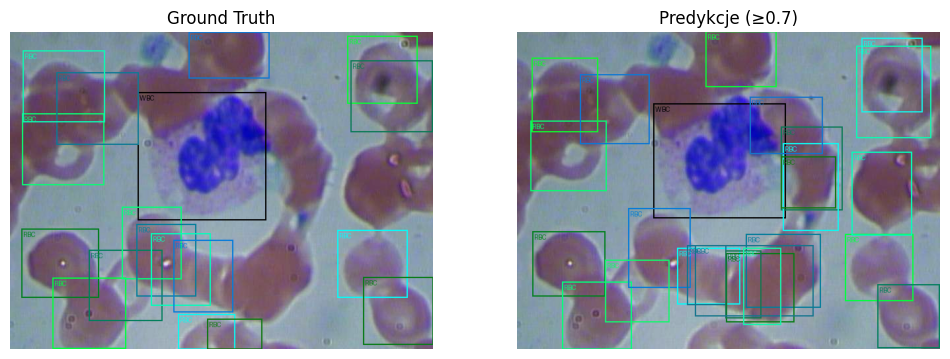

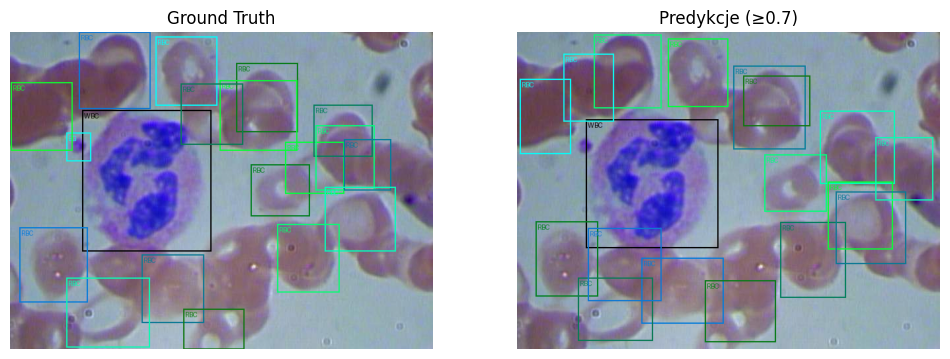

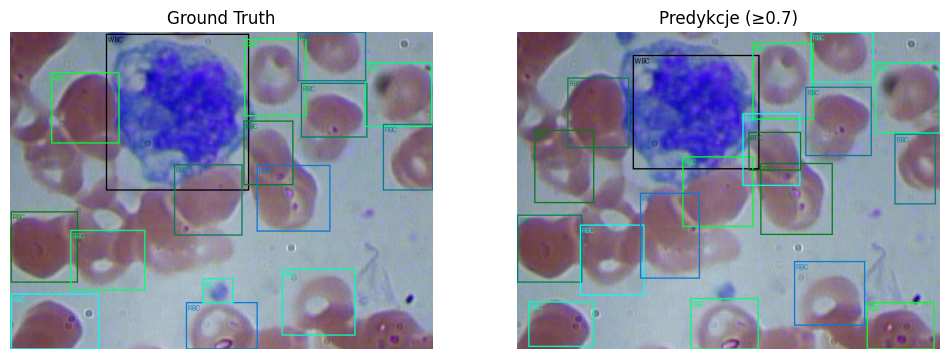

In [24]:
best_ckpt = Path(ckpt_dir) / Path(Path(ckpt_cb.best_model_path).name)
if best_ckpt.exists():
    print("Wczytuję:", best_ckpt)
    best_model = DetectorLit.load_from_checkpoint(str(best_ckpt), num_classes=NUM_CLASSES, lr=5e-4)
else:
    print("Brak checkpointu; używam bieżącego modelu.")
    best_model = model

best_model.to(device).eval()

@torch.no_grad()
def visualize_predictions(dloader, n=3, score_thresh=0.3):
    imgs, tgts = next(iter(dloader))
    preds = best_model([img.to(device) for img in imgs])
    for i in range(min(n, len(imgs))):
        img = (((imgs[i] - imgs[i].min()) / (imgs[i].max() - imgs[i].min())) * 255).to(torch.uint8)
        gt_boxes = tgts[i]["boxes"]
        gt_labels = tgts[i]["labels"].cpu()
        pr_boxes = preds[i]["boxes"].cpu()
        pr_scores = preds[i]["scores"].cpu()
        pr_labels = preds[i]["labels"].cpu()

        keep = pr_scores >= score_thresh
        pr_boxes = pr_boxes[keep]
        pr_labels = pr_labels[keep]

        # labels_txt_gt = ["GT"] * len(gt_boxes)
        labels_txt_gt = [IDX_TO_NAME.get(l.item(), "BG") for l in gt_labels]
        labels_txt_pr = [IDX_TO_NAME.get(l.item(), "BG") for l in pr_labels]

        img_gt = draw_bounding_boxes(img, boxes=gt_boxes, labels=labels_txt_gt, width=2)
        img_pr = draw_bounding_boxes(img, boxes=pr_boxes, labels=labels_txt_pr, width=2)

        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1); plt.imshow(to_pil_image(img_gt)); plt.title("Ground Truth"); plt.axis("off")
        plt.subplot(1,2,2); plt.imshow(to_pil_image(img_pr)); plt.title(f"Predykcje (≥{score_thresh})"); plt.axis("off")
        plt.show()

test_loader = dm.test_dataloader()
visualize_predictions(test_loader, n=3, score_thresh=0.7)


---

## Podsumowanie i wnioski

Odpowiedz krótko na poniższe pytania.

1. Wyjaśnij pojęcie **anchor boxes** — po co są używane w sieciach detekcyjnych?
predefiniowane prostokąty o danych rozmiarach i proporcjach, służące jako punkty wyjściowe do przewidywania obiektów
2. Jaką rolę pełni **RPN** (Region Proposal Network) w architekturze sieci detekcyjnej?
Generuje propozycje regionów (bounding boxów) prawdopodobnie zawierających obiekty
3. Wyjaśnij działanie **NMS** (Non-Maximum Suppression) — dlaczego jest używane?
Usuwa nakładające się przewidywania, zostawiając tylko te o najwyższym prawdopodobieństwie, aby uniknąć wielu detekcji tego samego obiektu